#**What are Word Embeddings?**

**Word Embeddings** are an n-dimensional vector space representing  words such that semantically similar words (for instance, “boat” — “ship”) or semantically related words (for instance, “boat” — “water”) are closer in the vector space according to a space metrics called cosine distance (or reversely cosine similarity). The type and quality of word embeddings depends on the training process and training set. 

The semantic relatedness come from the documents context and, basically, the words are used as context. These methods all belong to Unsupervise Learning in **NLP** (Natural Language Processing) and are powerful tools for extracting information from unstructured texts in an unsupervised way. 

**Word Embeddings** are a **Statistical Tool** to create a Language Model in **Machine Learning** for the application field called **Natural Language Processing**. 



Embedding 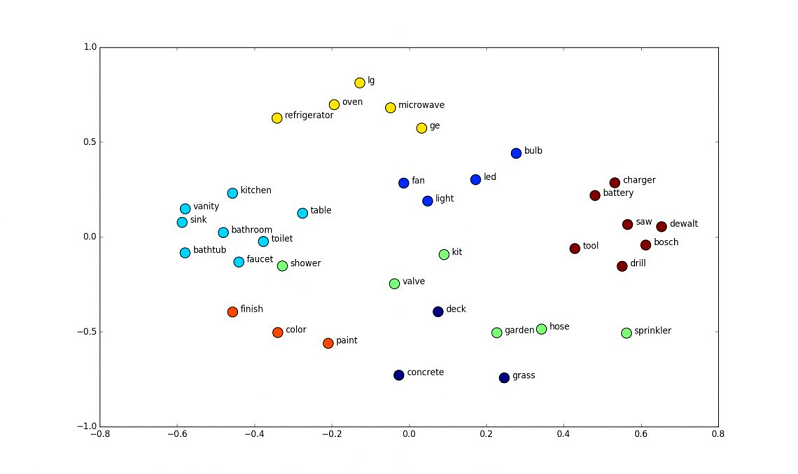

**Embedding Vectors** are calculated from the probability distribution for each word appearing before or after another. Namely, words of the same context usually appear together in the corpus, so they will be close in the vector space as well.

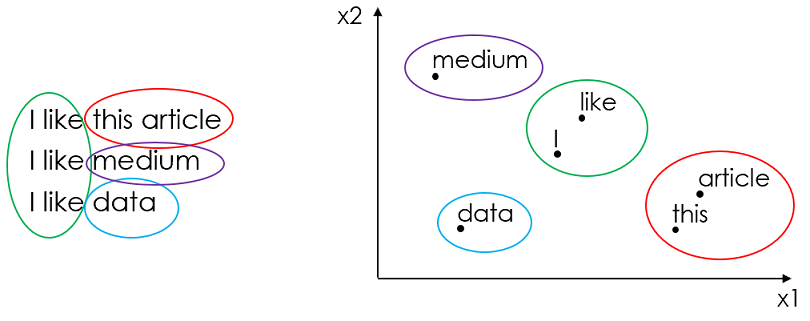

# **Word2Vec**

**Word2Vec** is tool for building language models via word embeddings.  It mainly uses two types of arlgorithms to produce vector representation of words:

1.   Continuous Bag-of-Words (CBOW)
2.   Skip-Gram 
    
In **CBOW**, the model predicts the most likely word in the given context. So, the words which have equal likelihood of appearing are considered as the similar and hence occur closer in the dimension space. For instance, if we consider, in a sentence, to replace ‘boat’ with ‘ship’, then the model predicts the probability for both and if comes out to be similar then we can say that the words are similar.

**Skip-Grams** is similar to CBOW, but, in this case, the model predicts the context using the given word.

**Word2Vec** are a set of techniques to extract information from raw text data and use it to train a classification model.

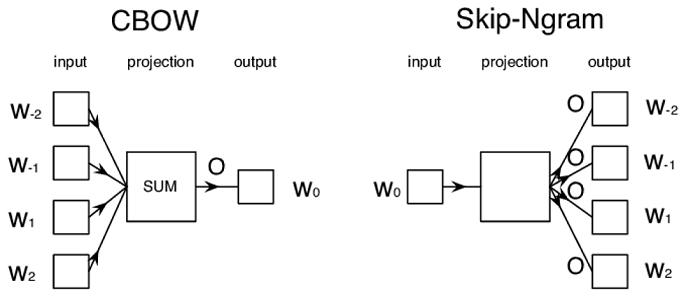

# **All Imports**

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import platform
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phrases, Phraser 
import gensim.downloader as gensim_api
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, Input, LSTM, Dense 
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import to_categorical

# **All Initializations**

In [2]:
OS = platform.system()   # Operating System
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **All Globals**

In [3]:
pretrained_embeddings = False

# **All General Functions Definitions**

In [4]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

# **Data Download**

In [5]:
out = data_download("./News_Category_Dataset_v2.zip", "1O0JTnVgHcYppkR5hmj8sxkpgP4dI164C", OS)
category_dicts = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        category_dicts.append(json.loads(dic))

# **Data Preprocessing**

In [6]:
data = pd.DataFrame(category_dicts)
data = data[data["category"].isin(['ENTERTAINMENT','POLITICS','TECH'])][["category","headline"]]
data = data.rename(columns={"category":"labels", "headline":"text"})
data = data[['text', 'labels']]     # move cols
explore_data(data)


Head of Data: 
                                                 text         labels
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT
2    Hugh Grant Marries For The First Time At Age 57  ENTERTAINMENT
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  ENTERTAINMENT
4  Julianna Margulies Uses Donald Trump Poop Bags...  ENTERTAINMENT
5  Morgan Freeman 'Devastated' That Sexual Harass...  ENTERTAINMENT

Tail of Data: 
                                                      text labels
200844    Google+ Now Open for Teens With Some Safeguards   TECH
200845                                           Web Wars   TECH
200846  First White House Chief Technology Officer, An...   TECH
200847         Watch The Top 9 YouTube Videos Of The Week   TECH
200848  RIM CEO Thorsten Heins' 'Significant' Plans Fo...   TECH

Shape of Data:  (50879, 2)

Information about Data: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50879 entries, 1 to 200848
Data columns (total 2 columns):
 #  

#**Data Exploration**

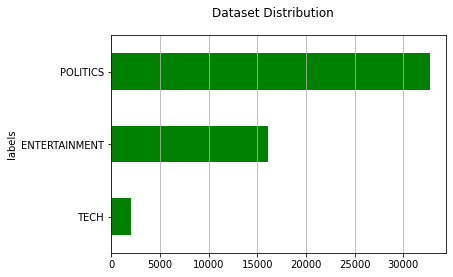

In [7]:
fig, ax = plt.subplots()
fig.suptitle("Dataset Distribution", fontsize=12)
data["labels"].reset_index().groupby("labels").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax, color = "green").grid(axis='x')
plt.show()

# **Data Cleaning Function Definition**

Let's now consider a set of cleaning operation for every Natural Language Processing application 

**1) Converts to lowercase and remove punctuations and characters and then strip.** 

We will use **Regular Expressions** in python: 

**RE** provides regular expression matching operations similar to those found in Perl.

**re.sub(pattern, repl, string, count=0, flags=0)**
*Returns the string obtained by replacing the leftmost non-overlapping occurrences of pattern in string by the replacement repl. If the pattern isn’t found, string is returned unchanged. repl can be a string or a function; if it is a string, any backslash escapes in it are processed. That is, \n is converted to a single newline character, \r is converted to a carriage return, and so forth. Unknown escapes of ASCII letters are reserved for future use and treated as errors. Other unknown escapes such as \& are left alone. Backreferences, such as \6, are replaced with the substring matched by group 6 in the pattern.* 

**The regular expression \W\S** matches a sequence of two characters; one non-word, and one non-space. If you want to combine them, that's [^\w\s] which matches one character which does not belong to either the word or the whitespace group.

**2) Tokenizes and Converts from string to list**

In NLP, **Tokenization** is the process splitting a sentence, paragraph, or a whole text into smaller units, such as individual words or terms. Each of these smaller units are called **tokens**.

**3) Removes Stopwords**

When working with text applications, we usually find term “stop words” or “stop word list” or even “stop list”.**Stop words** are basically a set of commonly used words in any language, not just English.

The reason why stop words are critical to many applications is that, if we remove the words that are very commonly used in a given language, we can focus on the important words instead. For example, in the context of a search engine, if your search query is “how to develop information retrieval applications”, If the search engine tries to find web pages that contained the terms “how”, “to” “develop”, “information”, ”retrieval”, “applications” the search engine is going to find a lot more pages that contain the terms “how”, “to” than pages that contain information about developing information retrieval applications because the terms “how” and “to” are so commonly used in the English language. If we disregard these two terms, the search engine can actually focus on retrieving pages that contain the keywords: “develop” “information” “retrieval” “applications” – which would bring up pages that are actually of interest. This is just the basic intuition for using stop words.

Some Stop Words are: 

**Determiners** – Determiners tend to mark nouns where a determiner usually will be followed by a noun
examples: the, a, an, another

**Coordinating conjunctions** – Coordinating conjunctions connect words, phrases, and clauses
examples: for, an, nor, but, or, yet, so

**Prepositions** – Prepositions express temporal or spatial relations
examples: in, under, towards, before


**NLTK:** is a platform for building Python programs to work with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning, wrappers for industrial-strength NLP libraries, and an active discussion forum.


**NLTK corpus readers:** The modules in this package provide functions that can be used to read corpus files in a variety of formats. These functions can be used to read both the corpus files that are distributed in the NLTK corpus package, and corpus files that are part of external corpora.

**nltk.corpus.stopwords:** provides the list of stopwords in every language

**4) Stemming (removes -ing, -ly, ...)**

**Stemming** is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma. Stemming is important in natural language understanding (NLU) and natural language processing (NLP).

For grammatical reasons, documents are going to use different forms of a word, such as *organize*, *organizes*, and *organizing*. Additionally, there are families of derivationally related words with similar meanings, such as *democracy*, *democratic*, and *democratization*. In many situations, it seems as if it would be useful for a search for one of these words to return documents that contain another word in the set.

**nltk.stem.porter.PorterStemmer:** Stemmers removing morphological affixes from words, leaving only the word stem.

**5) Lemmatisation (converts the word into root word)**

**Lemmatization** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma

**nltk.stem.wordnet.WordNetLemmatizer:** Lemmatize using WordNet’s built-in morphy function. Returns the input word unchanged if it cannot be found in WordNet.

**WordNet:** is a large lexical database of English. Nouns, verbs, adjectives and adverbs are grouped into sets of cognitive synonyms (synsets), each expressing a distinct concept. 




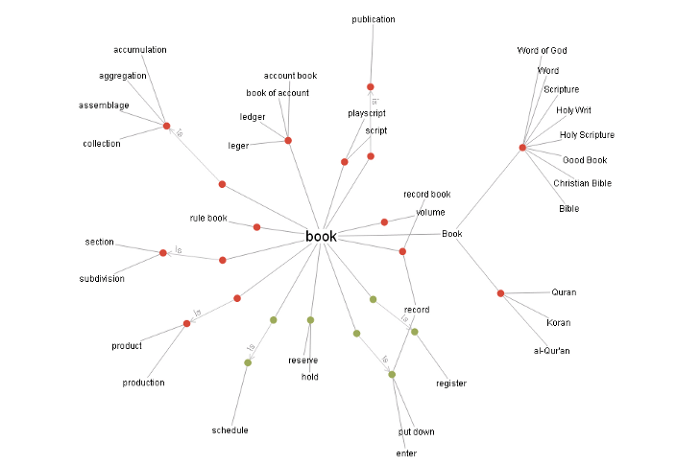

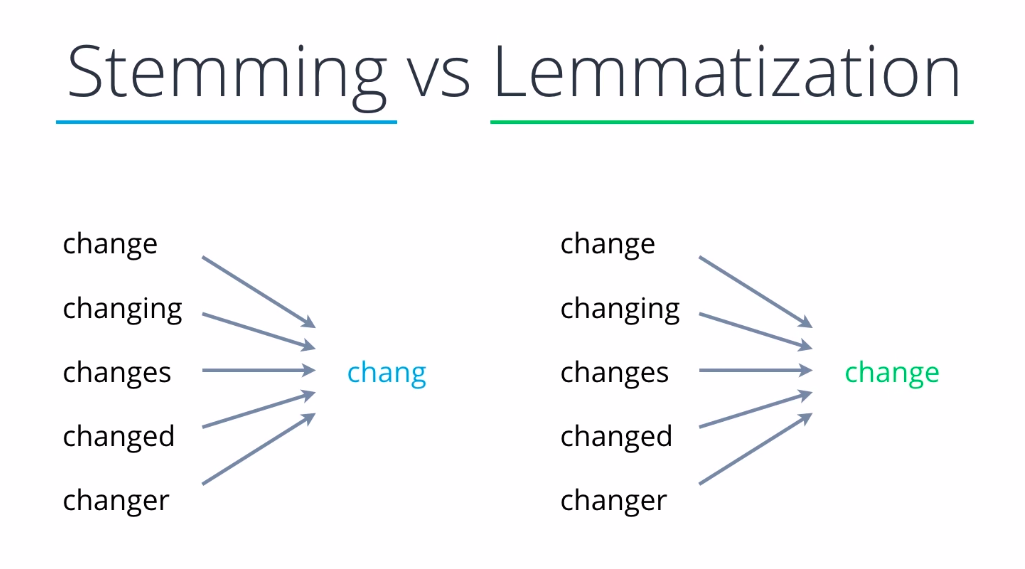

**6) back to string from list**

In [8]:
def clean_text(text, stemming=False, remove_stopwords = True, lemmatization=True, language = 'english', print_stopwords = False):
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip()) # (1)  
  lst_text = text.split()                                  # (2)
  if remove_stopwords: 
    lst_stopwords = nltk.corpus.stopwords.words(language)
    
    if lst_stopwords is not None:                          # (3)
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    if print_stopwords: 
      print(lst_text)

  if stemming:                                             # (4)
      ps = nltk.stem.porter.PorterStemmer()
      lst_text = [ps.stem(word) for word in lst_text]
              
  if lemmatization:                                        # (5) 
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      lst_text = [lem.lemmatize(word) for word in lst_text]
          
  text = " ".join(lst_text)                                # (6)
  
  return text

# **Data Cleaning**

In [9]:
data["text_clean"] = data["text"].apply(lambda x: clean_text(x, remove_stopwords = True, stemming=True, lemmatization=True)) 
explore_data(data)


Head of Data: 
                                                 text         labels  \
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT   
2    Hugh Grant Marries For The First Time At Age 57  ENTERTAINMENT   
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  ENTERTAINMENT   
4  Julianna Margulies Uses Donald Trump Poop Bags...  ENTERTAINMENT   
5  Morgan Freeman 'Devastated' That Sexual Harass...  ENTERTAINMENT   

                                          text_clean  
1  smith join diplo nicki jam 2018 world cup offi...  
2                 hugh grant marri first time age 57  
3  jim carrey blast castrato adam schiff democrat...  
4  julianna marguli use donald trump poop bag pic...  
5  morgan freeman devast sexual harass claim coul...  

Tail of Data: 
                                                      text labels  \
200844    Google+ Now Open for Teens With Some Safeguards   TECH   
200845                                           Web Wars   TECH   
20084

# **Data Preparation**

Split dataset and get the target


In [10]:
train_set, test_set = train_test_split(data, test_size=0.2)
train_y = train_set["labels"].values
test_y = test_set["labels"].values

In [11]:
print(len(train_set))
print(len(test_set))
print(len(train_y))
print(len(test_y))

40703
10176
40703
10176


#**Embedding Layer with Gensim**

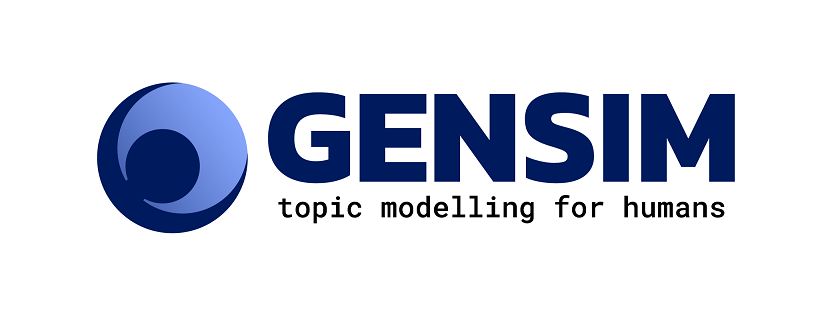

**Gensim** is a free open-source Python library for representing documents as semantic vectors, as efficiently (computer-wise) and painlessly (human-wise) as possible.

**Gensim** is designed to process raw, unstructured digital texts (“plain text”) using unsupervised machine learning algorithms.

The algorithms in Gensim, such as Word2Vec, FastText, Latent Semantic Indexing (LSI, LSA, LsiModel), Latent Dirichlet Allocation (LDA, LdaModel) etc, automatically discover the semantic structure of documents by examining statistical co-occurrence patterns within a corpus of training documents. These algorithms are unsupervised, which means no human input is necessary – you only need a corpus of plain text documents.

Once these statistical patterns are found, any plain text documents (sentence, phrase, word…) can be succinctly expressed in the new, semantic representation and queried for topical similarity against other documents (words, phrases…).

**gensim_api.load:** module is an API for downloading, getting information and loading datasets/models.

**gensim.models.phrases.Phrases:** Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a stream of sentences.

**gensim.models.word2vec.Word2Vec:** implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces. The word2vec algorithms include skip-gram and CBOW models, using either hierarchical softmax or negative sampling. The training is streamed, so ``sentences`` can be an iterable, reading input data from the disk or network on-the-fly, without loading your entire corpus into RAM.

**Critical Parameters:**

**sentences (iterable of iterables, optional):** The sentences iterable can be simply a list of lists of tokens, but for larger corpora, consider an iterable that streams the sentences directly from disk/network. See BrownCorpus, Text8Corpus or LineSentence in word2vec module for such examples. See also the tutorial on data streaming in Python. If you don’t supply sentences, the model is left uninitialized – use if you plan to initialize it in some other way.

**corpus_file (str, optional):** Path to a corpus file in LineSentence format. You may use this argument instead of sentences to get performance boost. Only one of sentences or corpus_file arguments need to be passed (or none of them, in that case, the model is left uninitialized).

**size or vector_size (int, optional):** Dimensionality of the word vectors.

**window (int, optional):** Maximum distance between the current and predicted word within a sentence.

**min_count (int, optional):** Ignores all words with total frequency lower than this.

**iter or epochs (int, optional):** Number of iterations (epochs) over the corpus. (Formerly: iter)

**sg ({0, 1}, optional):** Training algorithm: 1 for skip-gram; otherwise CBOW.

In [12]:
if pretrained_embeddings is True: 
  nlp = gensim_api.load("word2vec-google-news-300")
else: 
  corpus = train_set["text_clean"]

  # 1 - create list of lists of unigrams
  lst_corpus = []
  for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

  # 2 - create a list of bigrams and trigrams
  bigrams_detector = Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)                     # Train a bigram model.
  bigrams_detector = Phraser(bigrams_detector)                                                                  # Export the trained model = use less RAM, faster processing
  trigrams_detector = Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)  # Train a trigram model.
  trigrams_detector = Phraser(trigrams_detector)

In [13]:
print(type(lst_corpus))
print(type(bigrams_detector))
print(type(trigrams_detector))
print(len(lst_corpus))

<class 'list'>
<class 'gensim.models.phrases.Phraser'>
<class 'gensim.models.phrases.Phraser'>
40703


# **Word Embeddings Training by Gensim Word2Vec**

In [14]:
embedding_model = Word2Vec(lst_corpus, size=300, window=8, min_count=1, sg=1, iter=30)
embedding_model.save("news_category_word2vec_embeddings.model")

#**Language Model Sanity Check**

In [15]:
word = "data"
embedding_model[word].shape
print("Embeddings Coefficients for the word: ", word)
print("\n")
print(embedding_model[word])

Embeddings Coefficients for the word:  data


[ 2.83935517e-01 -4.96795848e-02 -9.66836959e-02  5.20126581e-01
  4.17756677e-01  6.61115527e-01  8.48151743e-01  1.14674471e-01
  1.88556165e-02 -2.59125799e-01  8.31756771e-01  2.67087728e-01
  3.22639108e-01  1.13633135e-03 -2.32739031e-01 -4.64552850e-01
  6.13013729e-02  1.77770481e-01 -2.97304280e-02 -2.18506455e-01
  3.13490123e-01 -1.03629954e-01  2.02512696e-01  9.82327270e-04
 -4.16826546e-01  3.30883354e-01 -3.31593931e-01  5.14693893e-02
  3.30538690e-01 -2.33156756e-01  3.40281337e-01 -1.03435159e-01
  8.53470862e-01  4.81764406e-01 -1.85931385e-01  9.46638882e-01
 -4.05595183e-01 -1.65885180e-01  1.92651197e-01 -1.79839192e-03
 -1.54204845e-01  2.16241449e-01  2.96925511e-02 -5.62177360e-01
  3.21385324e-01 -6.73974335e-01  1.14885844e-01 -4.00734216e-01
 -2.26037279e-01 -2.84723282e-01 -9.91113186e-02 -1.49201974e-01
  6.74388111e-02 -1.43533498e-01  9.69199896e-01  3.31750423e-01
 -1.09748557e-01 -5.60378805e-02  3.72541130

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


#**Embedding Space Visualization Function**

Extracts the 20 more similar word embeddings and make use of pca to reduce dimensionality from 300 to 3, in order to plot vectors

In [16]:
def embedding_space_visualization(root_word, model, plot_3d = True, plot_2d = False):
  fig = plt.figure(figsize=(20, 17), dpi=80)
  tot_words = [word] + [tupla[0] for tupla in model.most_similar(word, topn=30)]   
  X = model[tot_words]
  if plot_3d: 
    pca = TSNE(perplexity=40, n_components=3, init='pca')                           

    X = pca.fit_transform(X)
    pca_data = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    pca_data["input"] = 0
    pca_data["input"].iloc[0:1] = 1

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[pca_data["input"]==0]['x'], pca_data[pca_data["input"]==0]['y'], pca_data[pca_data["input"]==0]['z'], c="black")
    ax.scatter(pca_data[pca_data["input"]==1]['x'], pca_data[pca_data["input"]==1]['y'], pca_data[pca_data["input"]==1]['z'], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
    for label, row in pca_data[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)

# **Plot the Embedding Space**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithC

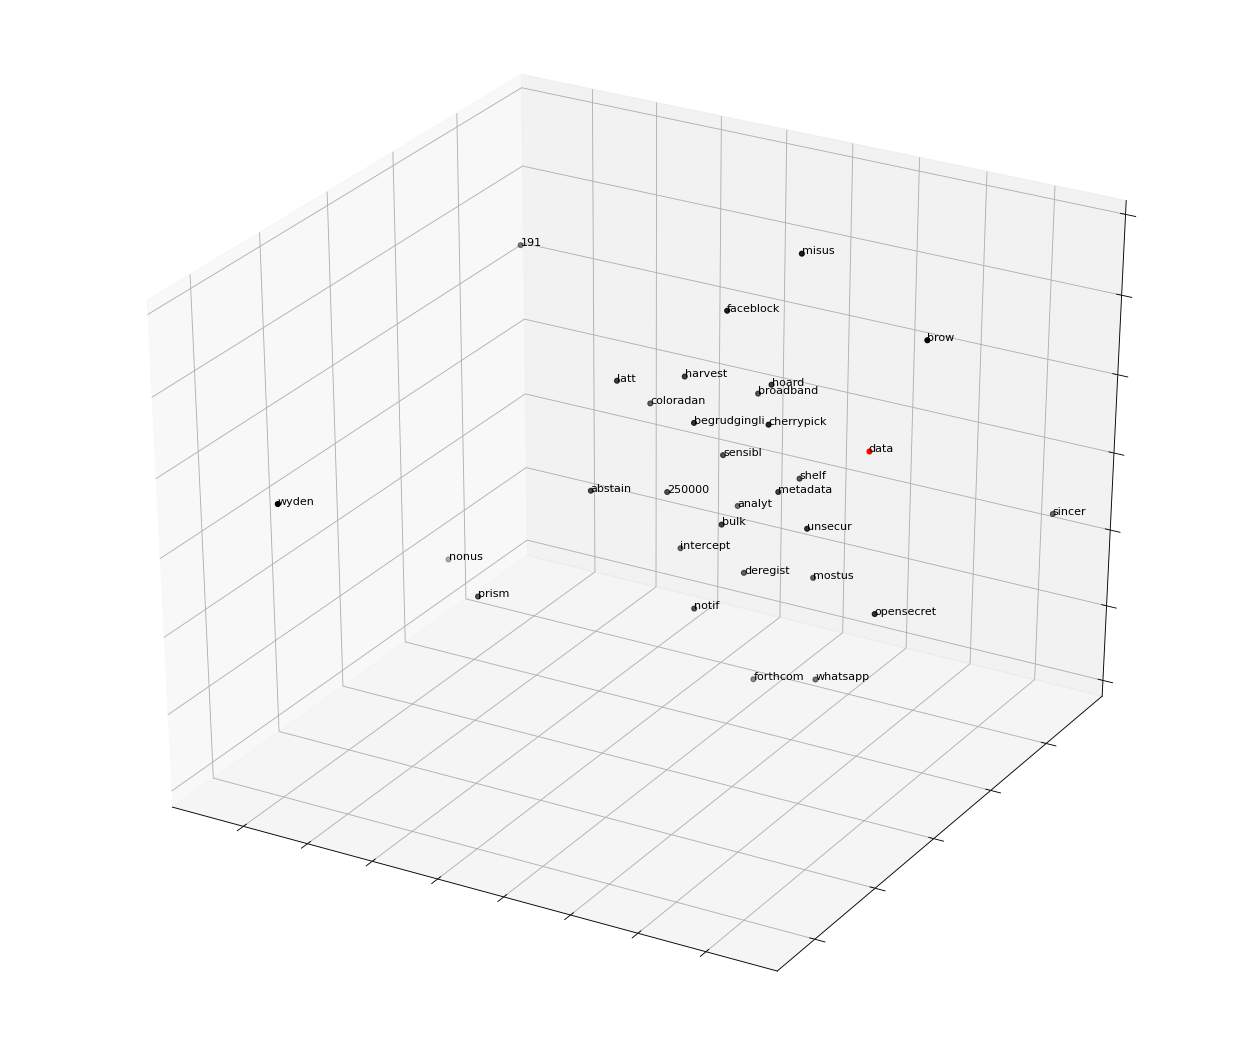

In [17]:
embedding_space_visualization("data", embedding_model)

 # **Feature Engineering**

In [18]:
tokenizer = Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # tokenize text
tokenizer.fit_on_texts(lst_corpus)
index_of_words = tokenizer.word_index
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)    ## create sequence
train_x = pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post") # pad sequences 


corpus = test_set["text_clean"]

lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

test_x = pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

In [20]:
print(train_x)
print(len(train_x))
print(test_x)
print(len(test_x))

[[  12  106  835 ...    0    0    0]
 [  11    5  338 ...    0    0    0]
 [  82  332  319 ...    0    0    0]
 ...
 [ 707 2163  162 ...    0    0    0]
 [ 148 4109  253 ...    0    0    0]
 [  86 6188   13 ...    0    0    0]]
40703
[[ 5041    64  1206 ...     0     0     0]
 [  274     1     1 ...     0     0     0]
 [   27    77    30 ...     0     0     0]
 ...
 [    1  1630     0 ...     0     0     0]
 [    1   893  1799 ...     0     0     0]
 [ 1317  1282 10572 ...     0     0     0]]
10176


# **Embeddings Matrix Building**

In [21]:
embeddings_matrix = np.zeros((len(index_of_words)+1, 300))
for word, idx in index_of_words.items():
    try:
        embeddings_matrix[idx] =  embedding_model[word]
    except:
        pass
print(embeddings_matrix.shape)

(18537, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


# **Labels Encoding**

In [22]:
print("Original Labels: ")
print(train_y)
print(test_y)
lb_train = LabelEncoder()
lb_train.fit(train_y)
train_y = lb_train.transform(train_y)

lb_test = LabelEncoder()
lb_test.fit(test_y)
test_y = lb_test.transform(test_y)

# save label file so we can use in another script
np.save('./train_labels.npy', lb_train.classes_)
np.save('./test_labels.npy', lb_test.classes_)
print("Encoded Labels: ")
print(train_y)
print(test_y)


Original Labels: 
['POLITICS' 'POLITICS' 'POLITICS' ... 'ENTERTAINMENT' 'POLITICS'
 'POLITICS']
['ENTERTAINMENT' 'POLITICS' 'POLITICS' ... 'POLITICS' 'POLITICS'
 'ENTERTAINMENT']
Encoded Labels: 
[1 1 1 ... 0 1 1]
[0 1 1 ... 1 1 0]


# **One-Hot Encoding of Outputs**

In [23]:
print("Original Labels: ")
print(train_y)
print(test_y)
train_y = to_categorical(train_y, num_classes = 3)
test_y = to_categorical(train_y, num_classes = 3)
print("One-Hot Encoded Labels: ")
print(train_y)
print(test_y)
print(len(train_y))
print(len(test_y))


Original Labels: 
[1 1 1 ... 0 1 1]
[0 1 1 ... 1 1 0]
One-Hot Encoded Labels: 
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[[[1. 0. 0.]
  [0. 1. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [1. 0. 0.]]

 ...

 [[0. 1. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [1. 0. 0.]]]
40703
40703


# **Deep Learning Model Definition**

We use a **Bidirectional** wrapper for RNNs and these two layers of Bidirectional LSTM are useful to model the order of words in a sequence in both directions. Return_sequences parameter for LSTM is used to return the last output, in the output sequence, or the full sequence, and it's necessary for the Bidirectional. 

**Bidirectional** long-short term memory(bi-lstm) is the process of making any neural network o have the sequence information in both directions backwards (future to past) or forward(past to future). In bidirectional, our input flows in two directions, making a bi-lstm different from the regular LSTM. With the regular LSTM, we can make input flow in one direction, either backwards or forward. However, in bi-directional, we can make the input flow in both directions to preserve the future and the past information. 

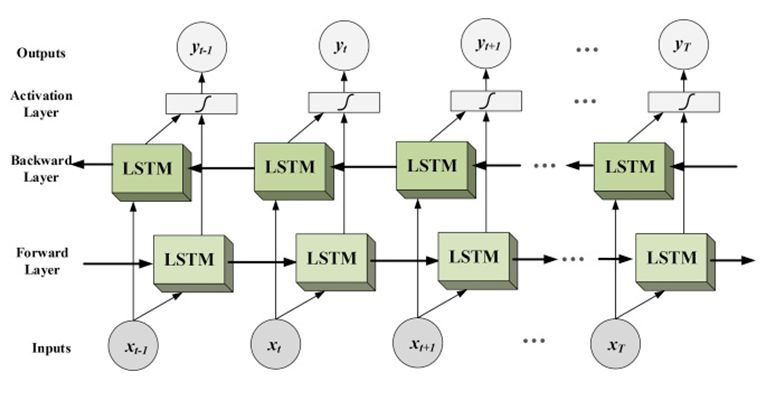

In [25]:
input = Input(shape=(15,))
x = Embedding(input_dim=embeddings_matrix.shape[0], output_dim=embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=15, trainable=False)(input)
x = Bidirectional(LSTM(units=15, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(units=15, dropout=0.2))(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding (Embedding)       (None, 15, 300)           5561100   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 30)           37920     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 dense_1 (Dense)             (None, 3)                 195   

# **Deep Learning Model Training**

In [26]:
training = model.fit(train_x, train_y, batch_size=64, epochs=3, shuffle=True, verbose=1, validation_split=0.2)

Epoch 1/3
509/509 [==============================] - 30s 39ms/step - loss: 0.2888 - accuracy: 0.8988 - val_loss: 0.2088 - val_accuracy: 0.9265
Epoch 2/3
509/509 [==============================] - 18s 36ms/step - loss: 0.1989 - accuracy: 0.9303 - val_loss: 0.1930 - val_accuracy: 0.9318
Epoch 3/3
509/509 [==============================] - 18s 35ms/step - loss: 0.1816 - accuracy: 0.9361 - val_loss: 0.1872 - val_accuracy: 0.9324


# **Homeworks**

1) Recreate Word Embeddings on 20NewsGroup and IMDB Sentiment Dataset

2) Plot the Embeddings for both starting from a chosen root word

2) Retrain the Bidirectional LSTM on 20NewsGroup and IMDB Sentiment Dataset 

3) Add all the requried Callbacks and Save Best Model

4) Make pre and post processing exploratory analysis of true and predicted labels

5) Plot confusion matrices 

6) Add f1-score to the training process 

7) Test the model on test set with accuracy and test set 

8) Find the best Deep Learning model tuning the hyperparameters in order to find the best accuracies and f1-scores